# Object Detection Batch Inference with PyTorch & torchvision

This example demostrates how to do object detection batch inference at scale with a pre-tained PyTorch model and Ray Data.

Here is what you'll do:
1. Perform object detection on a single image with a pre-trained PyTorch model.
1. Scale the PyTorch model with Ray Data, and perform object detection batch inference on a large set of images.
1. Verify the inference results and save them to an external storage.
1. Learn how to use Ray Data with multiple GPU workers.


## Before You Begin

Install the following dependencies if you haven't already.

In [ ]:
!pip install torchvision ipywidgets tabulate


## Object Detection on a single Image with PyTorch

First, let's take a look at this [object detection example](https://pytorch.org/vision/stable/models.html#object-detection) from PyTorch's official documentation. 

This example includes the following steps:
1. Download an image file from the Internet.
2. Load and intialize a pre-trained PyTorch model.
3. Apply inference preprocessing transforms.
4. Use the model for inference.
5. Visualize the result.

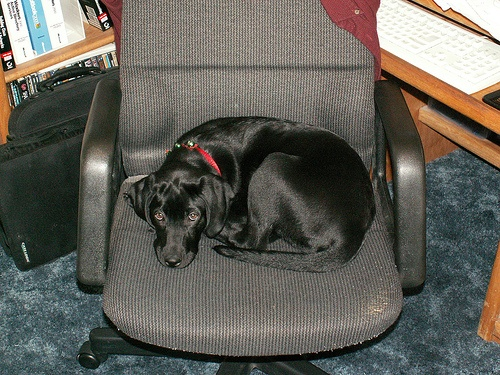

/Users/chenh/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


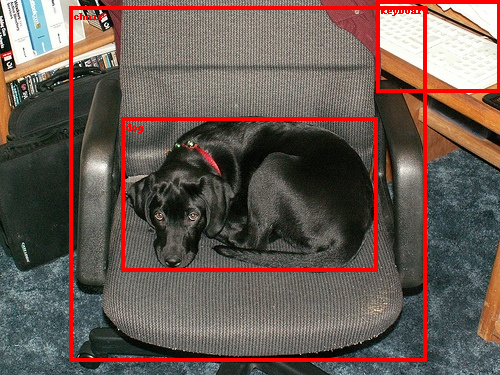

In [1]:
import requests
from PIL import Image
from torchvision import transforms
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# 1: Download an image file from the Internet.
url = "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg"
img = Image.open(requests.get(url, stream=True).raw)
display(img)

# 2: Load and intialize the model.
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# 3: Apply inference preprocessing transforms.
img = transforms.Compose([transforms.PILToTensor()])(img)
preprocess = weights.transforms()
batch = [preprocess(img)]

# 4: Use the model for interence.
prediction = model(batch)[0]

# 5: Visualize the result.
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
display(im)

## Parallelizing with Ray Data

Then we will scale the previous example to a large set of images. We will use Ray Data to do batch inference in a distributed fashion.

### Loading Image Dataset

First, we use the {meth}`ray.data.read_images <ray.data.read_images>` API to read image data from S3. 

In [2]:
import ray

ds = ray.data.read_images("s3://anonymous@air-example-data/AnimalDetection/JPEGImages")
display(ds.schema())

Usage stats collection is disabled.


2023-05-10 19:10:49,875	INFO worker.py:1616 -- Started a local Ray instance.
2023-05-10 19:10:56,304	WARNING dataset.py:251 -- Important: Ray Data requires schemas for all datasets in Ray 2.5. This means that standalone Python objects are no longer supported. In addition, the default batch format is fixed to NumPy. To revert to legacy behavior temporarily, set the environment variable RAY_DATA_STRICT_MODE=0 on all cluster processes.

Learn more here: https://docs.ray.io/en/master/data/faq.html#migrating-to-strict-mode


Schema({'image': numpy.ndarray(ndim=3, dtype=uint8)})

### Understanding Batching

To boost performance with hardware acceleration, we usually do inference in batches. In Ray Data, a batch is by default defined as a `Dict[str, np.ndarray]`. 

In the following code snippet, we use the {meth}`take_batch <ray.data.dataset.Dataset.take_batch>` API to fetch a single batch and inspect its internal data structure. As we can see, the batch is a dict that has one key named "image", and the value is an array of images represented in the `np.ndarray` format.

In [3]:
single_batch = ds.take_batch(batch_size=3)
display(single_batch)

{'image': array([array([[[172, 154, 144],
                [255, 248, 239],
                [255, 246, 244],
                ...,
                [255, 255, 246],
                [237, 234, 225],
                [214, 211, 202]],
 
               [[123, 105,  95],
                [255, 249, 240],
                [251, 244, 238],
                ...,
                [255, 252, 245],
                [255, 254, 247],
                [247, 244, 237]],
 
               [[ 54,  38,  25],
                [255, 253, 241],
                [250, 247, 238],
                ...,
                [248, 247, 243],
                [248, 247, 243],
                [254, 253, 249]],
 
               ...,
 
               [[ 64,  79,  86],
                [ 61,  74,  80],
                [104, 113, 118],
                ...,
                [ 94, 105, 109],
                [ 90,  99, 104],
                [ 83,  92,  97]],
 
               [[ 69,  86,  93],
                [ 68,  83,  88],
               

### Batch inference with Ray Data

Then let's use Ray Data to scale the PyTorch example and do batch inference in a distributed fashion.

As we can see from the PyTorch example, model inference consists of 2 steps: preprocessing the image and apply the model. 

To convert the previous example to Ray Data, first let's define a `preprocess_image` function that packages the preprocessing code.

In [4]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.detection import (FasterRCNN_ResNet50_FPN_V2_Weights,
                                          fasterrcnn_resnet50_fpn_v2)
from typing import Dict
from ray.data.extensions.tensor_extension import create_ragged_ndarray


def preprocess_image(input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    preprocessor = transforms.Compose(
        [transforms.ToTensor(), weights.transforms()]
    )
    return {
        "image": input_batch["image"],
        "transformed": create_ragged_ndarray([preprocessor(image).numpy() for image in input_batch["image"]]),
    }

Then let's define a `ObjectDetectionModel` class that packages the model inference code. The reason why we use a class instead of a function here is because loading and initializing a model is expensive. So we put them in the `__init__` constructor, which will run only once. And we put the model inference code in the `__call__` function, which will be called for each batch.


In [5]:
class ObjectDetectionModel:
    def __init__(self):
        # Define the model loading and initialization code in `__init__`
        self.weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        self.model = fasterrcnn_resnet50_fpn_v2(
            weights=self.weights,
            box_score_thresh=0.9,
        )
        self.model.eval()

    def __call__(self, input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        # Define the per-batch inference code in `__call__`
        batch = [torch.from_numpy(image) for image in input_batch["transformed"]]
        predictions = self.model(batch)
        return {
            "image": input_batch["image"],
            "labels": create_ragged_ndarray([pred["labels"].detach().numpy() for pred in predictions]),
            "boxes": create_ragged_ndarray([pred["boxes"].detach().numpy() for pred in predictions]),
        }

Then, we use the {meth}`map_batches <ray.data.dataset.Dataset.map_batches>` API to apply these 2 steps to the whole image data set. Here, the `batch_size` argument indicates the number of images in each batch. 

In [6]:
ds = ds.map_batches(
    preprocess_image,
    batch_size=100,
).map_batches(
    ObjectDetectionModel,
    compute=ray.data.ActorPoolStrategy(size=4),
    batch_size=4,
)

### Verify and Save Results

Then let's take a few sampales and verify the inference results with visualization.

In [ ]:
from torchvision.transforms.functional import convert_image_dtype, to_tensor

batch = ds.take_batch(batch_size=3)
for image, labels, boxes in zip(batch["image"], batch["labels"], batch["boxes"]):
    image = convert_image_dtype(to_tensor(image), torch.uint8)
    labels = [weights.meta["categories"][i] for i in labels]
    boxes = torch.from_numpy(boxes)
    img = to_pil_image(draw_bounding_boxes(
        image,
        boxes,
        labels=labels,
        colors="red",
        width=4,
        font_size=30,
    ))
    display(img)

2023-05-10 19:10:58,799	INFO streaming_executor.py:91 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->MapBatches(preprocess_image)->MapBatches(ObjectDetectionModel)]
2023-05-10 19:10:58,800	INFO streaming_executor.py:92 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-05-10 19:10:58,800	INFO streaming_executor.py:94 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-05-10 19:10:58,816	INFO actor_pool_map_operator.py:114 -- ReadImage->MapBatches(preprocess_image)->MapBatches(ObjectDetectionModel): Waiting for 4 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported stoarge and file formats.

In [ ]:
ds.write_parquet("local://tmp/inference_results")

### Using GPUs

Ray Data can also work on GPU workers. To make the previous example work with GPUs, we only need to make some small changes.

```diff
         self.model = fasterrcnn_resnet50_fpn_v2(
             weights=self.weights,
             box_score_thresh=0.9,
-        )
+        ).cuda()
         self.model.eval()
         # Note, since the data in the batch input is `np.ndarray`s,
         # we need `transforms.ToTensor` to convert the data to torch tensors.
```

```diff
     def __call__(self, batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
         # Define the per-batch inference code in `__call__`
         # Preprocess the images.
-        batch = [self.prepross(image) for image in batch["image"]]
+        batch = [self.prepross(image).cuda() for image in batch["image"]]
         # Do inference on the images.
         predictions = self.model(batch)
         # Get the inferred labels and convert it to a np.ndarray
```


```diff
 ds = ds.map_batches(
     ObjecytDetectionModel,
     compute=ray.data.ActorPoolStrategy(size=4),
     batch_size=16,
+    num_gpus=1,
 )
```

The `num_gpus` argument will tell Ray to schedule the `ObjecytDetectionModel` operator to GPU nodes.   